In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [81]:
df = pd.read_csv(r"C:\Users\kanha\Desktop\Sap_assignment\data\ner_dataset.csv", encoding = "ISO-8859-1")

In [82]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [90]:
df = df.dropna(subset=['Word'])
df['Sentence #'] = df['Sentence #'].ffill()
df = df.drop(columns=["POS"])

df.columns = ["sentence_id", "word", "tag"]
print(f"Dataset shape: {df.shape}")


Dataset shape: (1048565, 3)


C:\Users\kanha\AppData\Local\Temp\ipykernel_13932\1769458641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence #'] = df['Sentence #'].ffill()


In [84]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [91]:
# Unique words, tags, sentences
print(f"Total Words: {df['word'].nunique()}")
print(f"Total Sentences: {df['sentence_id'].nunique()}")
print(f"Total Tags: {df['tag'].nunique()}")

Total Words: 35177
Total Sentences: 47949
Total Tags: 17


In [92]:
# Most common tags
print("\nTag distribution:")
print(df["tag"].value_counts())


Tag distribution:
tag
O        887898
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64


In [93]:
# Average sentence length
sentence_lengths = df.groupby("sentence_id")["word"].count()
print(f"\nAvg sentence length: {sentence_lengths.mean():.2f}")
print(f"Max sentence length: {sentence_lengths.max()}")



Avg sentence length: 21.87
Max sentence length: 104


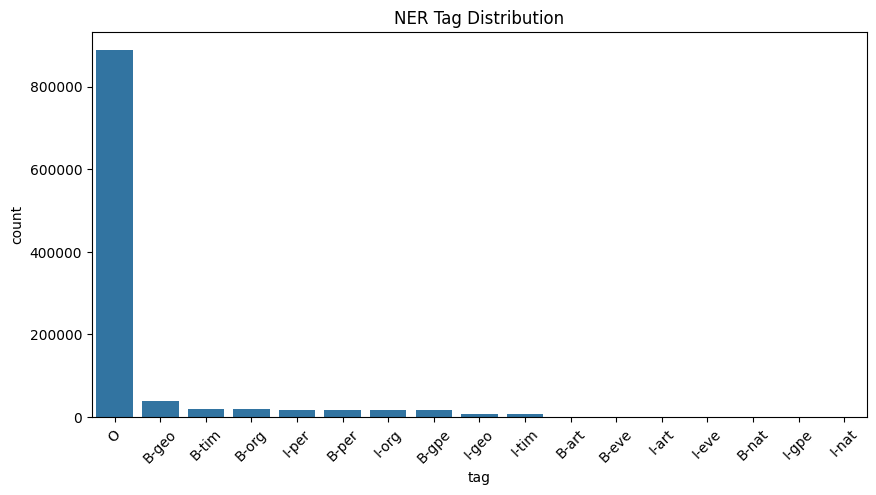

In [94]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="tag", order=df["tag"].value_counts().index)
plt.xticks(rotation=45)
plt.title("NER Tag Distribution")
plt.show()

In [95]:
df.head()

,sentence_id,word,tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [96]:
sentences = df.groupby("sentence_id")["word"].apply(list).tolist()
tags = df.groupby("sentence_id")["tag"].apply(list).tolist()

In [97]:
len(sentences)

47949

In [98]:
len(tags)

47949

In [99]:
X_train, X_temp, y_train, y_temp = train_test_split(sentences, tags, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [100]:
def word_features(sentence, i):
    """
    Extract features for word at position i in the sentence
    """
    word = sentence[i]
    features = {
        'word': word.lower(),
        'is_first': i == 0,
        'is_last': i == len(sentence) - 1,
        'is_capitalized': word[0].isupper(),
        'is_all_caps': word.isupper(),
        'is_all_lower': word.islower(),
        'prefix-1': word[0] if len(word) > 0 else '',
        'prefix-2': word[:2] if len(word) > 1 else '',
        'prefix-3': word[:3] if len(word) > 2 else '',
        'suffix-1': word[-1] if len(word) > 0 else '',
        'suffix-2': word[-2:] if len(word) > 1 else '',
        'suffix-3': word[-3:] if len(word) > 2 else '',
        'prev_word': sentence[i-1].lower() if i > 0 else '<START>',
        'next_word': sentence[i+1].lower() if i < len(sentence) - 1 else '<END>',
        'has_hyphen': '-' in word,
        'is_numeric': word.isdigit(),
        'is_alphanumeric': word.isalnum(),
        'length': len(word),
    }

    if i > 0:
        word1 = sentence[i - 1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
        })
    else:
        features['BOS'] = True

    if i < len(sentence) - 1:
        word1 = sentence[i + 1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
        })
    else:
        features['EOS'] = True
    return features

In [101]:
def sent2features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

In [102]:
# Extract features
X_train_feats = [sent2features(s) for s in X_train]
X_val_feats = [sent2features(s) for s in X_val]
X_test_feats = [sent2features(s) for s in X_test]

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1, 
    c2=0.1,  
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train_feats, y_train)

,algorithm,'lbfgs'
,min_freq,None
,all_possible_states,None
,all_possible_transitions,True
,c1,0.1
,c2,0.1
,max_iterations,100
,num_memories,None
,epsilon,None
,period,None
,delta,None


In [105]:
from seqeval.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score


y_pred_val = crf.predict(X_val_feats)

print("Validation Set Performance (Token Level):\n")
print(classification_report(y_val, y_pred_val))

print("Summary Metrics:")
print("Accuracy:  ", accuracy_score(y_val, y_pred_val))
print("Precision: ", precision_score(y_val, y_pred_val))
print("Recall:    ", recall_score(y_val, y_pred_val))
print("F1 Score:  ", f1_score(y_val, y_pred_val))

Validation Set Performance (Token Level):

              precision    recall  f1-score   support

         art       0.57      0.24      0.34        33
         eve       0.52      0.38      0.44        37
         geo       0.85      0.89      0.87      3761
         gpe       0.96      0.93      0.95      1611
         nat       0.62      0.21      0.31        24
         org       0.77      0.71      0.74      2004
         per       0.79      0.76      0.78      1709
         tim       0.90      0.87      0.89      1999

   micro avg       0.85      0.84      0.84     11178
   macro avg       0.75      0.62      0.66     11178
weighted avg       0.85      0.84      0.84     11178

Summary Metrics:
Accuracy:   0.9714111632600604
Precision:  0.8512072892938497
Recall:     0.8357487922705314
F1 Score:   0.843407213469959


# ***Advanced model***

In [ ]:
from collections import defaultdict

unique_tags = sorted(set(tag for tag_seq in tags for tag in tag_seq))
tag2id = {tag: idx for idx, tag in enumerate(unique_tags)}
id2tag = {idx: tag for tag, idx in tag2id.items()}

In [ ]:
def create_hf_ner_data(sentences, tag_sequences):
    dataset = []
    for tokens, tags in zip(sentences, tag_sequences):
        ner_ids = [tag2id[tag] for tag in tags]
        dataset.append({'tokens': tokens, 'ner_tags': ner_ids})
    return dataset

train_data = create_hf_ner_data(X_train, y_train)
val_data = create_hf_ner_data(X_val, y_val)
test_data = create_hf_ner_data(X_test, y_test)

In [ ]:
from datasets import Dataset
from transformers import BertTokenizerFast


train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                # Inside a word piece, use I- tag or repeat tag
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply to dataset
train_tokenized = train_ds.map(tokenize_and_align_labels, batched=True)
val_tokenized = val_ds.map(tokenize_and_align_labels, batched=True)


In [ ]:
##load model

from transformers import BertForTokenClassification

model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)


In [ ]:
##train the model

from transformers import TrainingArguments, Trainer
from seqeval.metrics import accuracy_score, f1_score, classification_report

def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=-1)

    true_labels = [
        [id2tag[l] for l, p in zip(label, pred) if l != -100]
        for label, pred in zip(labels, predictions)
    ]
    true_preds = [
        [id2tag[p] for l, p in zip(label, pred) if l != -100]
        for label, pred in zip(labels, predictions)
    ]

    return {
        "accuracy": accuracy_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
    }

training_args = TrainingArguments(
    output_dir="./ner-bert",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


In [ ]:
metrics = trainer.evaluate()
print(metrics)

In [ ]:
from transformers import pipeline

ner_pipe = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

print(ner_pipe("Barack Obama visited New Delhi."))